In [1]:
import datetime
import matplotlib.pyplot as plt
import multiprocessing
import os
import pandas as pd

In [2]:
TAG = "ECG200"

In [3]:
ts = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
results_folder = f'./results/{TAG}/{ts}'
os.makedirs(results_folder, exist_ok=True)

In [4]:
!which pip

/home/samir/miniconda3/envs/gendis/bin/pip


In [5]:
!pip freeze | grep GENDIS

GENDIS==1.0.13


In [6]:
from gendis.genetic import GeneticExtractor
from gendis.fitness import SubgroupDistance

In except import


/home/samir/miniconda3/envs/gendis/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
error_df = pd.read_csv(f'data/{TAG}/{TAG}_processed_error.csv')

In [8]:
error_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,truth,clf_pred,clf_prob,error
0,1.088076,1.564040,1.368890,1.250157,1.491498,1.682589,1.226951,0.343969,-0.335317,-0.729320,...,2.150796,2.385066,1.993872,1.760286,1.269218,0.399103,0,0,0.096398,0.096398
1,0.955804,1.603964,2.728597,4.147563,2.942624,1.382093,0.037531,-0.339903,0.465481,0.797179,...,-0.137032,-0.510956,-0.414687,-0.289843,-0.471944,-0.345898,1,1,0.970263,0.029737
2,1.709221,2.752852,1.682990,1.241862,-0.037972,-0.217589,0.789646,0.547428,0.302104,0.339065,...,0.111021,0.308668,0.048724,0.072167,0.348025,0.658488,1,1,0.986109,0.013891


In [9]:
X = error_df.drop(columns=['truth', 'clf_pred', 'clf_prob', 'error'])
y = error_df['error']

# Sampling
# X = X.sample(n=400)
# y = y[X.index]

In [10]:
y.describe()

count    100.000000
mean       0.196339
std        0.249543
min        0.000283
25%        0.023708
50%        0.078806
75%        0.284824
max        0.912535
Name: error, dtype: float64

In [11]:
help(GeneticExtractor)

Help on class GeneticExtractor in module gendis.genetic:

class GeneticExtractor(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Feature selection with genetic algorithm.
 |  
 |  Parameters
 |  ----------
 |  population_size : int
 |      The number of individuals in our population. Increasing this parameter
 |      increases both the runtime per generation, as the probability of
 |      finding a good solution.
 |  
 |  iterations : int
 |      The maximum number of generations the algorithm may run.
 |  
 |  wait : int
 |      If no improvement has been found for `wait` iterations, then stop
 |  
 |  add_noise_prob : float
 |      The chance that gaussian noise is added to a random shapelet from a
 |      random individual every generation
 |  
 |  add_shapelet_prob : float
 |      The chance that a shapelet is added to a random shapelet set every gen
 |  
 |  remove_shapelet_prob : float
 |      The chance that a shapelet is deleted to a random shap set every gen
 | 

In [12]:
DIST_THRESHOLD = 1.0

fitness_func = SubgroupDistance(
    distance_function=SubgroupDistance.wasserstein_distance, 
    shapelet_dist_threshold=DIST_THRESHOLD,
    min_support=10
)

args = {
    "fitness": fitness_func,
    "population_size": 50, 
    "iterations": 50,  
    "mutation_prob": 0.3, 
    "crossover_prob": 0.3,
    "max_shaps": 5,
    "wait": 20, 
    "min_len": 30,
    "max_len": 60,
    "n_jobs": multiprocessing.cpu_count() - 1,
    "verbose": True,
    "dist_threshold": DIST_THRESHOLD,
} 

gendis = GeneticExtractor(**args)

In [13]:
gendis.__dict__

{'population_size': 50,
 'iterations': 50,
 'verbose': True,
 'mutation_prob': 0.3,
 'crossover_prob': 0.3,
 'plot': None,
 'wait': 20,
 'n_jobs': 15,
 'normed': False,
 'min_len': 30,
 'max_len': 60,
 'max_shaps': 5,
 'init_ops': [<function gendis.operators.random_shapelet(X, n_shapelets, min_len_series, max_len, min_len=4)>,
  <function gendis.operators.kmeans(X, n_shapelets, min_len_series, max_len, n_draw=None, min_len=4)>],
 'cx_ops': [<function gendis.operators.merge_crossover(ind1, ind2, p=0.25)>,
  <function gendis.operators.point_crossover(ind1, ind2)>,
  <function gendis.operators.shap_point_crossover(ind1, ind2, p=0.25)>],
 'mut_ops': [<function gendis.operators.add_shapelet(shapelets, toolbox)>,
  <function gendis.operators.remove_shapelet(shapelets, toolbox)>,
  <function gendis.operators.mask_shapelet(shapelets, toolbox)>],
 'is_fitted': False,
 'dist_threshold': 1.0,
 'fitness': <gendis.fitness.SubgroupDistance at 0x7fe29779ca20>,
 'label_mapping': {},
 'shapelets': []}

In [14]:
%%time
gendis.fit(X, y.values)

it		avg		std		max		time
1		0.0066		0.017		0.074952	0.4547
2		0.0221		0.023		0.074952	0.4296
3		0.0538		0.074		0.261588	0.4199
4		0.0387		0.042		0.261588	0.3859
5		0.0385		0.042		0.261588	0.4363
6		0.0403		0.043		0.261588	0.5379
7		0.0575		0.053		0.261588	0.4457
8		0.1047		0.096		0.261588	0.4171
9		0.0805		0.079		0.261588	0.532
10		0.1048		0.097		0.261588	0.4429
11		0.1227		0.102		0.261588	0.4387
12		0.1077		0.095		0.261588	0.4867
13		0.1455		0.099		0.261588	0.4119
14		0.1476		0.103		0.261588	0.3766
15		0.153		0.106		0.261588	0.4263
16		0.1758		0.102		0.261588	0.4243
17		0.1866		0.101		0.261588	0.4493
18		0.172		0.114		0.261588	0.4084
19		0.201		0.1		0.261588	0.3924
20		0.1888		0.113		0.261588	0.3684
21		0.1828		0.114		0.261588	0.3581
22		0.1944		0.104		0.261588	0.4635
CPU times: user 11.2 s, sys: 972 ms, total: 12.2 s
Wall time: 14.6 s


In [15]:
gendis.save(f'{results_folder}/gendis.pickle')

In [16]:
gendis.best

{'it': 3,
 'score': 0.2615883817170509,
 'info': {'dist': 0.30067630082419644,
  'subgroup_error_mean': 0.15726039070619868,
  'rest_error_mean': 0.4578633814957741,
  'subgroup_size': 87},
 'shapelets': [array([0.25895364, 0.29370692, 0.4146716 , 0.38827139, 0.42373679,
         0.44592042, 0.54491549, 0.36647803, 0.44463197]),
  array([ 0.00216254,  0.18138724,  0.41296547,  0.20681063, -0.02556879,
         -0.18473672, -0.19089065, -0.24073482, -0.12378963])]}

In [17]:
gendis.top_10_best

[{'score': 0.2615883817170509,
  'info': {'dist': 0.30067630082419644,
   'subgroup_error_mean': 0.15726039070619868,
   'rest_error_mean': 0.4578633814957741,
   'subgroup_size': 87},
  'shapelets': [array([ 0.00216254,  0.18138724,  0.41296547,  0.20681063, -0.02556879,
          -0.18473672, -0.19089065, -0.24073482, -0.12378963])]},
 {'score': 0.2615883817170509,
  'info': {'dist': 0.30067630082419644,
   'subgroup_error_mean': 0.15726039070619868,
   'rest_error_mean': 0.4578633814957741,
   'subgroup_size': 87},
  'shapelets': [array([ 0.00216254,  0.18138724,  0.41296547,  0.20681063, -0.02556879,
          -0.18473672, -0.19089065, -0.24073482, -0.12378963])]},
 {'score': 0.2615883817170509,
  'info': {'dist': 0.30067630082419644,
   'subgroup_error_mean': 0.15726039070619868,
   'rest_error_mean': 0.4578633814957741,
   'subgroup_size': 87},
  'shapelets': [array([ 0.00216254,  0.18138724,  0.41296547,  0.20681063, -0.02556879,
          -0.18473672, -0.19089065, -0.24073482, 

In [18]:
shapelets = gendis.best["shapelets"]

In [19]:
sg_indexes, not_sg_indexes = gendis.get_subgroups(X, y, shapelets)

In [22]:
gendis.best

{'it': 3,
 'score': 0.2615883817170509,
 'info': {'dist': 0.30067630082419644,
  'subgroup_error_mean': 0.15726039070619868,
  'rest_error_mean': 0.4578633814957741,
  'subgroup_size': 87},
 'shapelets': [array([0.25895364, 0.29370692, 0.4146716 , 0.38827139, 0.42373679,
         0.44592042, 0.54491549, 0.36647803, 0.44463197]),
  array([ 0.00216254,  0.18138724,  0.41296547,  0.20681063, -0.02556879,
         -0.18473672, -0.19089065, -0.24073482, -0.12378963])]}

<module 'matplotlib.pyplot' from '/home/samir/miniconda3/envs/gendis/lib/python3.6/site-packages/matplotlib/pyplot.py'>

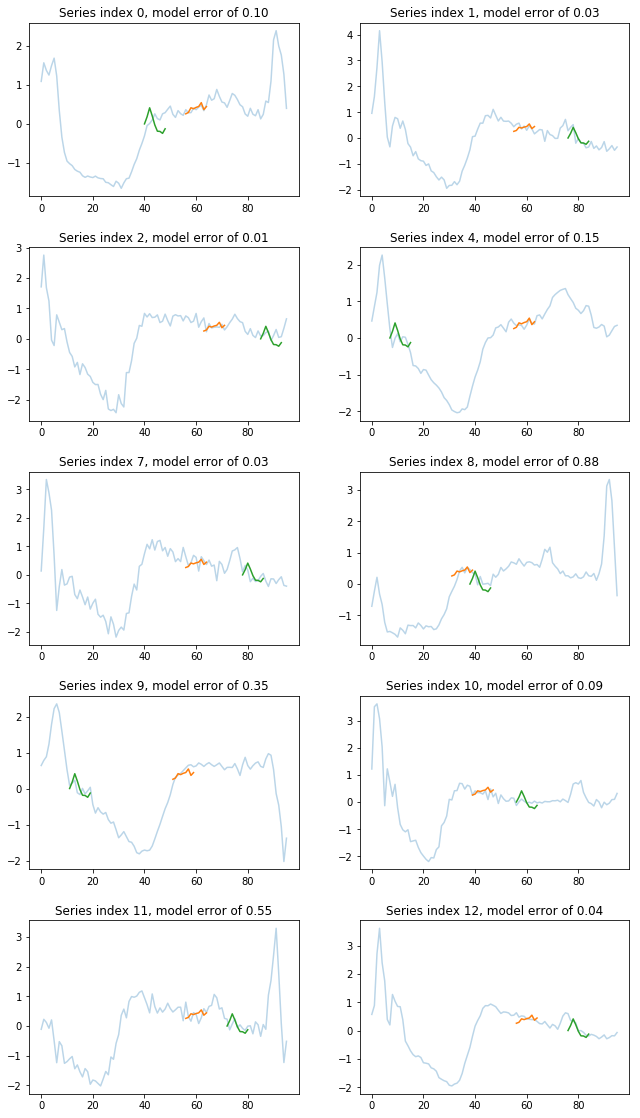

In [20]:
gendis.plot_series_and_shapelets(
    X=X,
    y=y,
    shapelets=shapelets,
    indexes_to_plot=sg_indexes,
)

<module 'matplotlib.pyplot' from '/home/samir/miniconda3/envs/gendis/lib/python3.6/site-packages/matplotlib/pyplot.py'>

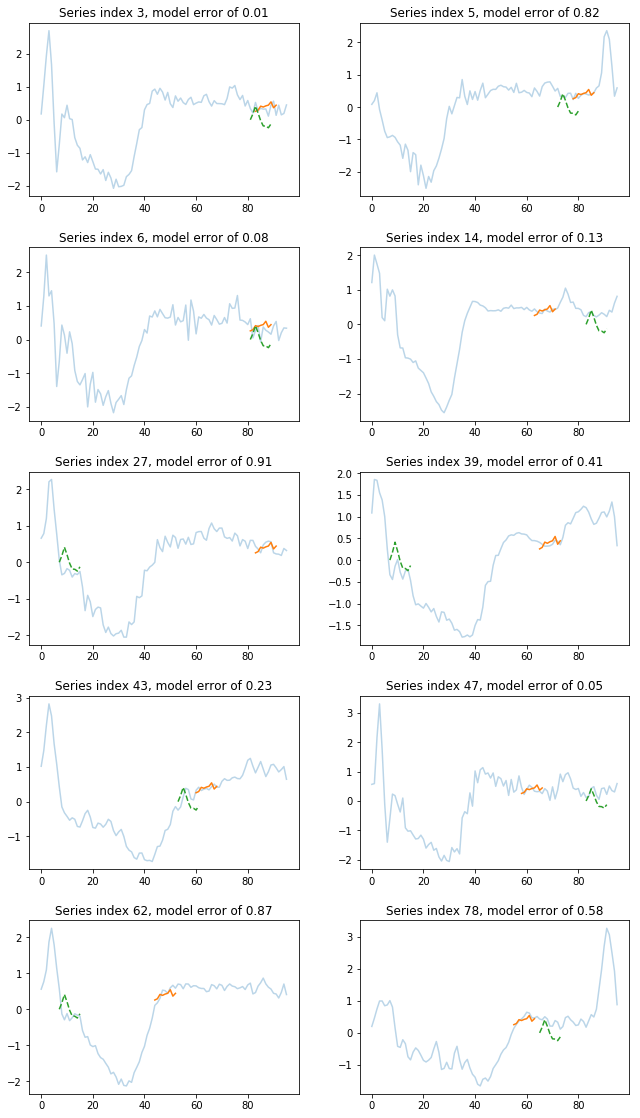

In [21]:
gendis.plot_series_and_shapelets(
    X=X,
    y=y,
    shapelets=shapelets,
    indexes_to_plot=not_sg_indexes,
)